# Programming Exercise 4 - Neural Networks Learning

In this exercise, you will implement the backpropagation algorithm for neural networks and apply it to the task of hand-written digit recognition.

# Neural Networks

In the previous exercise, you implemented feedforward propagation for neu- ral networks and used it to predict handwritten digits with the weights we provided. In this exercise, you will implement the backpropagation algorithm to learn the parameters for the neural network.

## Visualizing the data

This is the same dataset that you used in the previous exercise. There are 5000 training examples in `ex4data1.mat`, where each training example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector. Each of these training examples becomes a single row in our data matrix X. This gives us a 5000 by 400 matrix X where every row is a training example for a handwritten digit image.

$$ 
X = 
\begin{bmatrix} 
- \: (x^{(1)})^T \: - \\ -\: (x^{(2)})^T \:- \\ \vdots \\ - \: (x^{(m)})^T \:-  
\end{bmatrix} 
$$

The second part of the training set is a 5000-dimensional `vector y` that contains labels for the training set. A “0” digit is labeled as “10”, while the digits “1” to “9” are labeled as “1” to “9” in their natural order.

In [1]:
# In Python, we will use scipy module to load Matlab / Octave matrix

from scipy.io import loadmat
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [2]:
data = loadmat('data/ex4data1.mat')

X = data['X']

y = data['y']

X.shape, y.shape

((5000, 400), (5000, 1))

## Visualizing the data

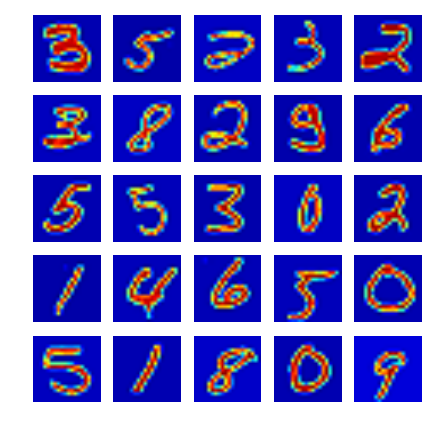

In [3]:
def displayData(X, y):
    _, axes = plt.subplots(5, 5, figsize=(5, 5))
    for i in range(5):
        for j in range(5):
            axes[i, j].imshow(X[np.random.randint(X.shape[0])].reshape((20,20), order='F'))          
            axes[i, j].axis('off')  
    plt.show()
    
displayData(X, y)

In [4]:
X = np.c_[np.zeros((X.shape[0], 1)), X]
X.shape

(5000, 401)

##  Model representation

Our neural network is shown in the below figure. 

![Neural network](https://github.com/dibgerge/ml-coursera-python-assignments/raw/8a606acb22f033360b2fbbf1a1266cc9ea391800/Exercise3/Figures/neuralnetwork.png)

It has 3 layers – an input layer, a hidden layer and an output layer. Recall that our inputs are pixel values of digit images. Since the images are of size 20×20, this gives us 400 input layer units (excluding the extra bias unit which always outputs +1). As before, the training data will be loaded into the variables X and y.

You have been provided with a set of network parameters ($\Theta^{(1)}$, $\Theta^{(2)}$) already trained by us. These are stored in ex4weights.mat. The following cell loads those parameters into  Theta1 and Theta2. The parameters have dimensions that are sized for a neural network with 25 units in the second layer and 10 output units (corresponding to the 10 digit classes).

## Feedforward and cost function

Now you will implement the cost function and gradient for the neural network. Recall that the cost function for the neural network (without regularization) is

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m}\sum_{k=1}^{K} \left[ - y_k^{(i)} \log \left( \left( h_\theta \left( x^{(i)} \right) \right)_k \right) - \left( 1 - y_k^{(i)} \right) \log \left( 1 - \left( h_\theta \left( x^{(i)} \right) \right)_k \right) \right]$$

where $h_\theta \left( x^{(i)} \right)$ is computed as shown in the neural network figure above, and K = 10 is the total number of possible labels. Note that  $h_\theta(x^{(i)})_k = a_k^{(3)}$ is the activation (output value) of the $k^{th}$ output unit. Also, recall that whereas the original labels (in the variable y) were 0, 1, ..., 9, for the purpose of training a neural network, we need to encode the labels as vectors containing only values 0 or 1, so that

$$ y = 
\begin{bmatrix} 1 \\ 0 \\ 0 \\\vdots \\ 0 \end{bmatrix}, \quad
\begin{bmatrix} 0 \\ 1 \\ 0 \\ \vdots \\ 0 \end{bmatrix}, \quad \cdots  \quad \text{or} \qquad
\begin{bmatrix} 0 \\ 0 \\ 0 \\ \vdots \\ 1 \end{bmatrix}.
$$
For example, if $x^{(i)}$ is an image of the digit 5, then the corresponding $y^{(i)}$ (that you should use with the cost function) should be a 10-dimensional vector with $y_5 = 1$, and the other elements equal to 0.

You should implement the feedforward computation that computes $h_\theta(x^{(i)})$ for every example $i$ and sum the cost over all examples. Your code should also work for a dataset of any size, with any number of labels (you can assume that there are always at least $K \ge 3$ labels).

**Implementation Note:** The matrix $X$ contains the examples in rows (i.e., X[i,:] is the i-th training example $x^{(i)}$, expressed as a $n \times 1$ vector.) When you complete the code in `nnCostFunction`, you will need to add the column of 1’s to the X matrix. The parameters for each unit in the neural network is represented in Theta1 and Theta2 as one row. Specifically, the first row of Theta1 corresponds to the first hidden unit in the second layer. You can use a for-loop over the examples to compute the cost.

In [5]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [6]:
def nnCostFunction(nn_params,
                   input_layer_size,
                   hidden_layer_size,
                   num_labels,
                   X, y, reg=None):
    
    # Reshape nn_params back into the parameters Theta1 and Theta2, the weight matrices
    # for our 2 layer neural network
    Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                        (hidden_layer_size, (input_layer_size + 1)))

    Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                        (num_labels, (hidden_layer_size + 1)))

    m = X.shape[0]
    
    # one-hot vector
    y_matrix = pd.get_dummies(y.ravel()).as_matrix()
    
    z2 = np.dot(Theta1, X.T)
    a2 = sigmoid(z2).T

    # add bias unit
    a2 = np.c_[np.zeros((m, 1)), a2]
    
    z3 = np.dot(Theta2, a2.T)
    a3 = sigmoid(z3)
    
    h = a3
    
    if reg:
        cost = -1 / m * np.sum(np.log(h).T * (y_matrix) + np.log(1 - h).T * (1 - y_matrix)) + \
                reg / (2 * m) * (np.sum(np.square(Theta1[:, 1:])) + np.sum(np.square(Theta2[:, 1:])))
    else:
        cost = -1 / m * np.sum(np.log(h).T * (y_matrix) + np.log(1 - h).T * (1 - y_matrix))
    
    return cost

Once you are done, call your nnCostFunction using the loaded set of parameters for Theta1 and Theta2. You should see that the cost is about 0.287629.

In [7]:
input_layer_size = 400
hidden_layer_size = 25
num_labels = 10

weights = loadmat('data/ex4weights.mat')
Theta1, Theta2 = weights['Theta1'], weights['Theta2']

# Unroll parameters 
nn_params = np.concatenate([Theta1.ravel(), Theta2.ravel()])

print(Theta1.shape)
print(Theta2.shape)
print(nn_params.shape)

(25, 401)
(10, 26)
(10285,)


In [8]:
cost = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y)

print('your cost is %.6f' % cost)

your cost is 0.324385


## Regularized cost function

The cost function for neural networks with regularization is given by

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m}\sum_{k=1}^{K} \left[ - y_k^{(i)} \log \left( \left( h_\theta \left( x^{(i)} \right) \right)_k \right) - \left( 1 - y_k^{(i)} \right) \log \left( 1 - \left( h_\theta \left( x^{(i)} \right) \right)_k \right) \right] + \frac{\lambda}{2 m} \left[ \sum_{j=1}^{25} \sum_{k=1}^{400} \left( \Theta_{j,k}^{(1)} \right)^2 + \sum_{j=1}^{10} \sum_{k=1}^{25} \left( \Theta_{j,k}^{(2)} \right)^2 \right] $$


You can assume that the neural network will only have 3 layers - an input layer, a hidden layer and an output layer. However, your code should work for any number of input units, hidden units and outputs units. While we have explicitly listed the indices above for $\Theta^{(1)}$ and $\Theta^{(2)}$ for clarity, do note that your code should in general work with $\Theta^{(1)}$ and $\Theta^{(2)}$ of any size. Note that you should not be regularizing the terms that correspond to the bias. For the matrices Theta1 and Theta2, this corresponds to the first column of each matrix. You can modify the above nnCostFunction to add the regularization term. By setting $\lambda$ = 1, you should see that the cost is about 0.383770.

In [9]:
reg = 1

cost = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, reg=reg)

print('your cost is %.6f' % cost)

your cost is 0.420526


# Backpropagation

In this part of the exercise, you will implement the backpropagation algorithm to compute the gradient for the neural network cost function. Once you have computed the gradient, you will be able to train the neural network by minimizing the cost function $J(\theta)$ using an advanced optimizer such as scipy's optimize.minimize. You will first implement the backpropagation algorithm to compute the gradients for the parameters for the (unregularized) neural network. After you have verified that your gradient computation for the unregularized case is correct, you will implement the gradient for the regularized neural network.


## Sigmoid Gradient

To help you get started with this part of the exercise, you will first implement the sigmoid gradient function. The gradient for the sigmoid function can be computed as

$$ g'(z) = \frac{d}{dz} g(z) = g(z)\left(1-g(z)\right) $$
where

$$ \text{sigmoid}(z) = g(z) = \frac{1}{1 + e^{-z}} $$
Now complete the implementation of sigmoidGradient in the next cell.

In [10]:
def sigmoidGradient(z):
    g_z = sigmoid(z)
    grad_g_z = g_z * (1 - g_z)
    
    return grad_g_z

For large values (both positive and negative) of z, the gradient should be close to 0. When z = 0, the gradient should be exactly 0.25.

In [11]:
z = np.array([-1, -0.5, 0, 0.5, 1])
g = sigmoidGradient(z)
print('Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]:\n  ')
print(g)

Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]:
  
[ 0.19661193  0.23500371  0.25        0.23500371  0.19661193]


## Random initialization

When training neural networks, it is important to randomly initialize the parameters for [symmetry breakinG](https://stackoverflow.com/a/20029817/). One effective strategy for random initialization is to randomly select values for $\Theta^{(l)}$ uniformly in the range $[-\epsilon_{init}, \epsilon_{init}]$. You should use $\epsilon_{init} = 0.12$. This range of values ensures that the parameters are kept small and makes the learning more efficient.

One effective strategy for choosing $\epsilon_{init}$ is to base it on the number of units in the network. A good choice of $\epsilon_{init}$ is $\epsilon_{init} = \frac{\sqrt{6}}{\sqrt{L_{in} + L_{out}}}$ where $L_{in} = s_l$ and $L_{out} = s_{l+1}$ are the number of units in the layers adjacent to $\Theta^{l}$.
Your job is to complete the function randInitializeWeights to initialize the weights for $\Theta$. Modify the function by filling in the following code:

```Python
# Randomly initialize the weights to small values
W = np.random.rand(L_out, 1 + L_in) * 2 * epsilon_init - epsilon_init
```
Note that we give the function an argument for $\epsilon$ with default value epsilon_init = 0.12.


In [12]:
def randInitializeWeights(L_in, L_out, epsilon_init=0.12):
    W = np.random.rand(L_out, 1 + L_in) * 2 * epsilon_init - epsilon_init
    return W

In [13]:
initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)

# Unroll parameters
initial_nn_params = np.concatenate([initial_Theta1.ravel(), initial_Theta2.ravel()], axis=0)

## Backpropagation

![Backpropagation](https://github.com/dibgerge/ml-coursera-python-assignments/raw/8a606acb22f033360b2fbbf1a1266cc9ea391800/Exercise4/Figures/ex4-backpropagation.png)

Now, you will implement the backpropagation algorithm. Recall that the intuition behind the backpropagation algorithm is as follows. Given a training example $(x^{(t)}, y^{(t)})$, we will first run a “forward pass” to compute all the activations throughout the network, including the output value of the hypothesis $h_\theta(x)$. Then, for each node $j$ in layer $l$, we would like to compute an “error term” $\delta_j^{(l)}$ that measures how much that node was “responsible” for any errors in our output.

For an output node, we can directly measure the difference between the network’s activation and the true target value, and use that to define $\delta_j^{(3)}$ (since layer 3 is the output layer). For the hidden units, you will compute $\delta_j^{(l)}$ based on a weighted average of the error terms of the nodes in layer $(l+1)$. In detail, here is the backpropagation algorithm (also depicted in the figure above). You should implement steps 1 to 4 in a loop that processes one example at a time. Concretely, you should implement a for-loop for t in range(m) and place steps 1-4 below inside the for-loop, with the $t^{th}$ iteration performing the calculation on the $t^{th}$ training example $(x^{(t)}, y^{(t)})$. Step 5 will divide the accumulated gradients by $m$ to obtain the gradients for the neural network cost function.

1. Set the input layer’s values $(a^{(1)})$ to the $t^{th }$training example $x^{(t)}$. Perform a feedforward pass, computing the activations $(z^{(2)}, a^{(2)}, z^{(3)}, a^{(3)})$ for layers 2 and 3. Note that you need to add a +1 term to ensure that the vectors of activations for layers $a^{(1)}$ and $a^{(2)}$ also include the bias unit. In numpy, if a 1 is a column matrix, adding one corresponds to a_1 = np.concatenate([np.ones((m, 1)), a_1], axis=1).

2. For each output unit $k$ in layer 3 (the output layer), set $$\delta_k^{(3)} = \left(a_k^{(3)} - y_k \right)$$ where $y_k \in \{0, 1\}$ indicates whether the current training example belongs to class $k$ $(y_k = 1)$, or if it belongs to a different class $(y_k = 0)$. You may find logical arrays helpful for this task (explained in the previous programming exercise).

3. For the hidden layer $l = 2$, set $$ \delta^{(2)} = \left( \Theta^{(2)} \right)^T \delta^{(3)} * g'\left(z^{(2)} \right)$$ Note that the symbol $*$ performs element wise multiplication in numpy.

4. Accumulate the gradient from this example using the following formula. Note that you should skip or remove $\delta_0^{(2)}$. In numpy, removing $\delta_0^{(2)}$ corresponds to delta_2 = delta_2[1:].

5. Obtain the (unregularized) gradient for the neural network cost function by dividing the accumulated gradients by $\frac{1}{m}$: $$ \frac{\partial}{\partial \Theta_{ij}^{(l)}} J(\Theta) = D_{ij}^{(l)} = \frac{1}{m} \Delta_{ij}^{(l)}$$

**Python/Numpy tip**: You should implement the backpropagation algorithm only after you have successfully completed the feedforward and cost functions. While implementing the backpropagation alogrithm, it is often useful to use the `shape` function to print out the shapes of the variables you are working with if you run into dimension mismatch errors.

After you have implemented the backpropagation algorithm, we will proceed to run gradient checking on your implementation. The gradient check will allow you to increase your confidence that your code is computing the gradients correctly.

In [14]:
def nnGrad(nn_params,
           input_layer_size,
           hidden_layer_size,
           num_labels,
           X, y, reg=None):
    # Reshape nn_params back into the parameters Theta1 and Theta2, the weight matrices
    # for our 2 layer neural network
    Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                        (hidden_layer_size, (input_layer_size + 1)))

    Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                        (num_labels, (hidden_layer_size + 1)))

    m = X.shape[0]
    
    # one-hot vector
    y_matrix = pd.get_dummies(y.ravel()).as_matrix()
    
    Delta1 = np.zeros(Theta1.shape)
    Delta2 = np.zeros(Theta2.shape)
    
    for t in range(m):
        # step 1
        # a1 has been added the bias term
        
        a1 = X
        z2 = np.dot(Theta1, a1.T)
        a2 = sigmoid(z2).T

        # add bias unit
        a2 = np.c_[np.zeros((m, 1)), a2]

        z3 = np.dot(Theta2, a2.T)
        a3 = sigmoid(z3)

        # step 2 
        d3 = a3.T - y_matrix
        
        # step 3
        # remove theta_0^2
        d2 = np.dot(Theta2[:, 1:].T, d3.T) * sigmoidGradient(z2) # 25x10 * 10x5000 * 25x5000 = 25x5000
        
        # step 4 
        Delta1 = d2.dot(a1) # 25x5000 * 5000x401 = 25x401
        Delta2 = d3.T.dot(a2) # 10x5000 * 5000x26 = 10x26
        
        Delta1 = Delta1 / m
        Delta2 = Delta2 / m
        # step 5
        if reg:
            Delta1[:, 1:] = Delta1[:, 1:] + reg / m * Theta1[:, 1:]
            Delta2[:, 1:] = Delta2[:, 1:] + reg / m * Theta2[:, 1:]
        else:
            pass
        
        grad = np.concatenate([Delta1.ravel(), Delta2.ravel()])
        
        return grad

## Gradient Checking

In your neural network, you are minimizing the cost function $J(\Theta)$. To perform gradient checking on your parameters, you can imagine “unrolling” the parameters $\Theta^{(1)}$, $\Theta^{(2)}$ into a long vector $\theta$. By doing so, you can think of the cost function being $J(\Theta)$ instead and use the following gradient checking procedure.

Suppose you have a function $f_i(\theta)$ that purportedly computes $\frac{\partial}{\partial \theta_i} J(\theta)$; you’d like to check if $f_i$ is outputting correct derivative values.

$$
\text{Let } \theta^{(i+)} = \theta + \begin{bmatrix} 0 \\ 0 \\ \vdots \\ \epsilon \\ \vdots \\ 0 \end{bmatrix}
\quad \text{and} \quad \theta^{(i-)} = \theta - \begin{bmatrix} 0 \\ 0 \\ \vdots \\ \epsilon \\ \vdots \\ 0 \end{bmatrix}
$$
So, $\theta^{(i+)}$ is the same as $\theta$, except its $i^{th}$ element has been incremented by $\epsilon$. Similarly, $\theta^{(i-)}$ is the corresponding vector with the $i^{th}$ element decreased by $\epsilon$. You can now numerically verify $f_i(\theta)$’s correctness by checking, for each $i$, that:

$$ f_i\left( \theta \right) \approx \frac{J\left( \theta^{(i+)}\right) - J\left( \theta^{(i-)} \right)}{2\epsilon} $$
The degree to which these two values should approximate each other will depend on the details of $J$. But assuming $\epsilon = 10^{-4}$, you’ll usually find that the left- and right-hand sides of the above will agree to at least 4 significant digits (and often many more).

You can use the below `checkGradient` (referred from [check_grad.py](https://gist.github.com/srikarplus/8ded43dc79736c559dced7dbdff5ecbc#file-check_grad-py) function to check the gradient. 

In [15]:
def checkGradient(nn_initial_params,nn_backprop_Params,input_layer_size, hidden_layer_size, num_labels,myX,myy,mylambda=0.):
    myeps = 0.0001
    flattened = nn_initial_params
    flattenedDs = nn_backprop_Params
    n_elems = len(flattened) 

    # Pick ten random elements, compute numerical gradient, compare to respective D's
    for i in range(10):
        x = int(np.random.rand()*n_elems)
        epsvec = np.zeros((n_elems,1))
        epsvec[x] = myeps

        cost_high = nnCostFunction(flattened + epsvec.flatten(),input_layer_size, hidden_layer_size, num_labels,myX,myy,mylambda)
        cost_low  = nnCostFunction(flattened - epsvec.flatten(),input_layer_size, hidden_layer_size, num_labels,myX,myy,mylambda)
        mygrad = (cost_high - cost_low) / float(2*myeps)
        print("Element: {0}. Numerical Gradient = {1:.9f}. BackProp Gradient = {2:.9f}.".format(x,mygrad,flattenedDs[x]))

In [16]:
nn_backprop_Params = nnGrad(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, reg=None)

checkGradient(nn_params,nn_backprop_Params,input_layer_size, hidden_layer_size, num_labels, X, y)

Element: 6174. Numerical Gradient = -0.000355008. BackProp Gradient = -0.000355008.
Element: 5596. Numerical Gradient = -0.000000304. BackProp Gradient = -0.000000304.
Element: 8367. Numerical Gradient = 0.000710206. BackProp Gradient = 0.000710206.
Element: 5970. Numerical Gradient = -0.000089852. BackProp Gradient = -0.000089852.
Element: 8656. Numerical Gradient = 0.000735307. BackProp Gradient = 0.000735307.
Element: 7002. Numerical Gradient = -0.001240602. BackProp Gradient = -0.001240602.
Element: 6895. Numerical Gradient = 0.000031605. BackProp Gradient = 0.000031605.
Element: 566. Numerical Gradient = -0.000423746. BackProp Gradient = -0.000423746.
Element: 9948. Numerical Gradient = -0.000241540. BackProp Gradient = -0.000241540.
Element: 6405. Numerical Gradient = 0.000008290. BackProp Gradient = 0.000008290.


## Regularized Neural Networks

After you have successfully implemented the backpropagation algorithm, you will add regularization to the gradient. To account for regularization, it turns out that you can add this as an additional term after computing the gradients using backpropagation.

Specifically, after you have computed $\Delta_{ij}^{(l)}$ using backpropagation, you should add regularization using

$$ \begin{align} 
& \frac{\partial}{\partial \Theta_{ij}^{(l)}} J(\Theta) = D_{ij}^{(l)} = \frac{1}{m} \Delta_{ij}^{(l)} & \qquad \text{for } j = 0 \\
& \frac{\partial}{\partial \Theta_{ij}^{(l)}} J(\Theta) = D_{ij}^{(l)} = \frac{1}{m} \Delta_{ij}^{(l)} + \frac{\lambda}{m} \Theta_{ij}^{(l)} & \qquad \text{for } j \ge 1
\end{align}
$$
Note that you should not be regularizing the first column of $\Theta^{(l)}$ which is used for the bias term. Furthermore, in the parameters $\Theta_{ij}^{(l)}$, $i$ is indexed starting from 1, and $j$ is indexed starting from 0. Thus,

$$
\Theta^{(l)} = \begin{bmatrix}
\Theta_{1,0}^{(i)} & \Theta_{1,1}^{(l)} & \cdots \\
\Theta_{2,0}^{(i)} & \Theta_{2,1}^{(l)} & \cdots \\
\vdots &  ~ & \ddots
\end{bmatrix}
$$

Now modify your code that computes grad in `nnGrad` to account for regularization.

## Learning parameters using `scipy.optimize.minimize`

After you have successfully implemented the neural network cost function and gradient computation, the next step we will use scipy's minimization to learn a good set parameters.

In [17]:
import scipy.optimize as opt

lambda_ = 1

nn_params_opt = opt.fmin_cg(maxiter=400, f=nnCostFunction, x0=nn_params, fprime=nnGrad, \
                        args=(input_layer_size, hidden_layer_size, num_labels, X, y.ravel(), lambda_))

Theta1_opt = np.reshape(nn_params_opt[:hidden_layer_size * (input_layer_size + 1)],
                    (hidden_layer_size, (input_layer_size + 1)))

Theta2_opt = np.reshape(nn_params_opt[(hidden_layer_size * (input_layer_size + 1)):],
                    (num_labels, (hidden_layer_size + 1)))

         Current function value: 0.317066
         Iterations: 400
         Function evaluations: 934
         Gradient evaluations: 934


## Prediction using learned parameters

After the training completes, we will proceed to report the training accuracy of your classifier by computing the percentage of examples it got correct. If your implementation is correct, you should see a reported training accuracy of about 95.3% (this may vary by about 1% due to the random initialization). It is possible to get higher training accuracies by training the neural network for more iterations. We encourage you to try training the neural network for more iterations (e.g., set maxiter to 400) and also vary the regularization parameter $\lambda$. With the right learning settings, it is possible to get the neural network to perfectly fit the training set.

In [18]:
def predict(Theta1, Theta2, X, y):
    m = X.shape[0]
    
    a1 = X
    z2 = np.dot(Theta1, a1.T)
    a2 = sigmoid(z2).T

    # add bias unit
    a2 = np.c_[np.zeros((m, 1)), a2]

    z3 = np.dot(Theta2, a2.T)
    a3 = sigmoid(z3)
    
    h = a3.T 
    pred = np.argmax(h, axis=1) + 1
    
    acc = np.mean(pred == y.ravel()) * 100
    
    return acc

In [19]:
acc = predict(Theta1_opt, Theta2_opt, X, y)
print('Prediction accuracy is %.2f.' % acc)

Prediction accuracy is 99.50.


# Visualizing the hidden layer

One way to understand what your neural network is learning is to visualize what the representations captured by the hidden units. Informally, given a particular hidden unit, one way to visualize what it computes is to find an input $x$ that will cause it to activate (that is, to have an activation value ($a_i^{(l)}$) close to 1). For the neural network you trained, notice that the $i^{th}$ row of $\Theta^{(1)}$ is a 401-dimensional vector that represents the parameter for the $i^{th}$ hidden unit. If we discard the bias term, we get a 400 dimensional vector that represents the weights from each input pixel to the hidden unit.

Thus, one way to visualize the “representation” captured by the hidden unit is to reshape this 400 dimensional vector into a 20 × 20 image and display it (It turns out that this is equivalent to finding the input that gives the highest activation for the hidden unit, given a “norm” constraint on the input (i.e., $||x||_2 \le 1$)).

The next cell does this by using the `visualization` function and it will show you an image with 25 units, each corresponding to one hidden unit in the network. In your trained network, you should find that the hidden units corresponds roughly to detectors that look for strokes and other patterns in the input.

In [20]:
def visualization(X, example_width=None, figsize=(8, 8)):
    """
    Displays 2D data stored in X in a nice grid.
    """
    # Compute rows, cols
    if X.ndim == 2:
        m, n = X.shape
    elif X.ndim == 1:
        n = X.size
        m = 1
        X = X[None]  # Promote to a 2 dimensional array
    else:
        raise IndexError('Input X should be 1 or 2 dimensional.')

    example_width = example_width or int(np.round(np.sqrt(n)))
    example_height = n / example_width

    # Compute number of items to display
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    fig, ax_array = plt.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)

    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    for i, ax in enumerate(ax_array):
        # Display Image
        h = ax.imshow(X[i].reshape(example_width, example_width, order='F'),
                      cmap='Greys', extent=[0, 1, 0, 1])
        ax.axis('off')
    plt.show()

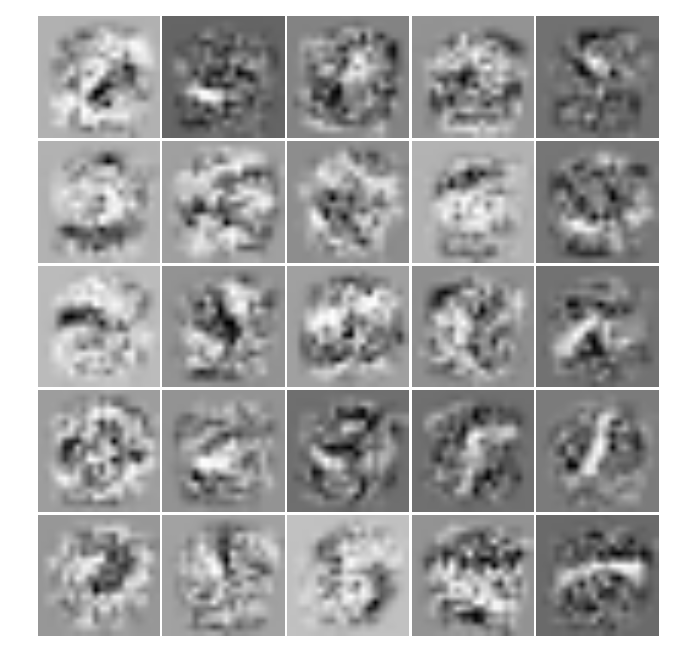

In [21]:
visualization(Theta1_opt[:, 1:])